In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import plotnine as gg
import umap
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

## Paths & reading features list

### Reading Single cell data

In [ ]:
foldername = "BR00100032"

csvlist = [os.path.join(Path("../" + foldername, i)) for i in os.listdir(Path("../" + foldername)) if "DMSO_FAK.csv" in i]

df = pd.read_csv(csvlist[0])

    
data = (df
        .drop(columns=['Unnamed: 0'])
       )


featlist = (np.loadtxt(Path("../" + 'metadata' + "/" + 'featureslist.txt'), 
                      dtype=str)
                    .tolist()
           )

metadata_file= foldername + "_Metadata.csv"


meta = pd.read_csv(Path("../" + foldername + "/" + metadata_file))


## Data_Preprocessing

In [ ]:

plotting_features = ["Metadata_Plate", "Metadata_Well","Nuclei_Location_Center_X", "Nuclei_Location_Center_Y",
 "PathName_OrigDNA", "Metadata_Well", "Metadata_Site","FileName_OrigDNA", 
 "PathName_NucleiOutlines", "FileName_OrigRNA","FileName_OrigMito",
 "FileName_OrigER", "FileName_OrigAGP","FileName_NucleiOutlines", 
 "Cells_Location_Center_X","Cells_Location_Center_Y", 
 "Cells_AreaShape_MajorAxisLength", "Cells_AreaShape_MinorAxisLength"]



newftlist = featlist + plotting_features


df_sel = data[data.columns[data.columns.isin(newftlist)]]




selected_wells = (data.Metadata_Well.unique()
                  .tolist()
                 )

selected_wells.remove('I04')


meta_modf = meta.query("Metadata_Well in @ selected_wells")


prf = pd.merge(meta_modf, df_sel, on=["Metadata_Well", "Metadata_Plate"], how="left")

prf.loc[prf['Metadata_compound_name'] == 'DMSO', "Metadata_Target"] = 'DMSO'

prf['Metadata_Target'].replace('CDK14 / pan-TAIRE', 'CDK14_pan-TAIRE', inplace=True)
prf['Metadata_Annotation'].replace('active ', 'active', inplace=True)



def z_normalization(data, selected_features):
    
    '''data    dataframe
    
       selected_features list of selected features'''
    
    meta = data[data.columns[~data.columns.isin(selected_features)]]
    
    dmso = data.query("Metadata_compound_name == 'DMSO'")
    
    scale = StandardScaler().fit(dmso[selected_features].values)
    
    scaled_data = scale.transform(data[selected_features].values)
    
    data_scaled = pd.merge(meta, pd.DataFrame(scaled_data, columns=selected_features), right_index=True, left_index=True, how="left")
    
    return data_scaled



data_scaled = z_normalization(prf, featlist)

data_scaled.head()


In [ ]:
target = ['DMSO', 'SECRET']

pf = data_scaled.query("Metadata_Target in @ target")

pf_variables = pf[featlist]
pf_meta = pf[pf.columns[~pf.columns.isin(featlist)]]

In [ ]:
data[featlist]

In [103]:

kmeans = KMeans(n_clusters=25, random_state=0).fit(data[featlist].values)
distances=kmeans.fit_transform(data[featlist].values)
data['labels'] = kmeans.labels_
data['dist2Mean'] = np.min(distances,1)



In [136]:
data.query("Metadata_Target == 'FAK'")['Metadata_Well'].unique()


array(['F05', 'F09', 'F18', 'F22', 'K03', 'K07', 'K16', 'K20'],
      dtype=object)

In [126]:
data.to_csv('DMSO_FAK_kmean.csv')

In [142]:
total_count = data.shape[0]
total_count

83466

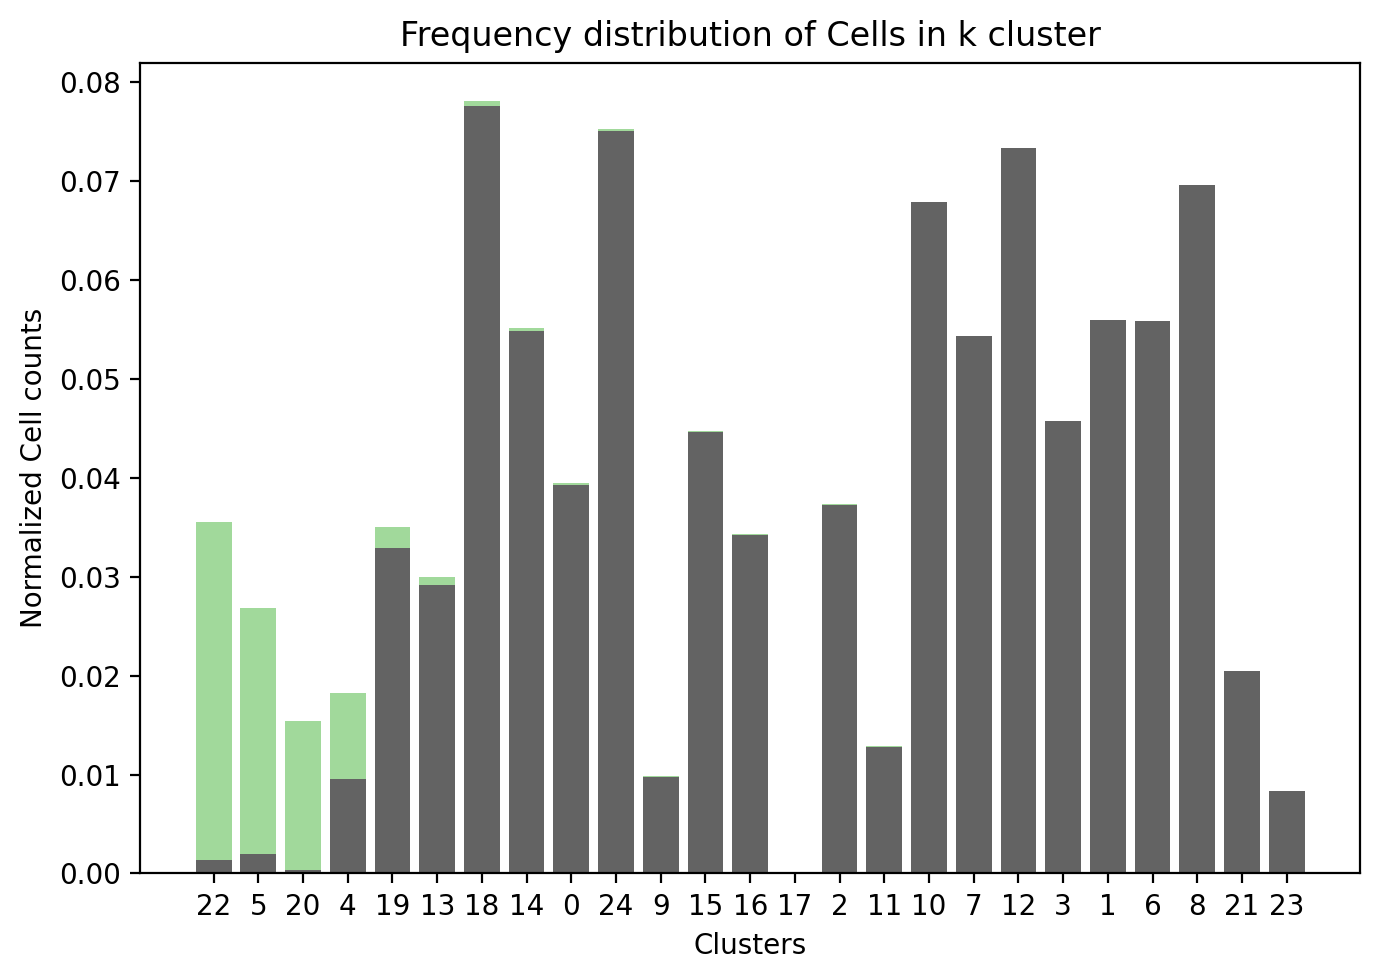

In [141]:
pff = pd.DataFrame()
for i in sorted(data.labels.unique()):
    tmp = data[data['labels']==i].groupby('Metadata_compound_name').count().reset_index()[['Metadata_compound_name', 'labels']]
    tmp[str(i)] = tmp['labels']/total_count
    
    pff = pd.concat([pff, tmp],axis=1)
    
pff = pff.loc[:,~pff.columns.duplicated()].T.reset_index()
pff.columns= pff.iloc[0]
pff.drop(pff.index[0:2], inplace=True)
pff = pff.assign(diff = lambda x: x['PND-1186'] - x['DMSO'])
pff = pff.sort_values(by=['PND-1186'], ascending=False)



width = 7
height = 5
dpi_inch = 200

plt.figure(
    figsize=(width, height),
    dpi=dpi_inch)


dmso = pff['DMSO'].tolist()
compd = pff['PND-1186'].tolist()
x = pff.Metadata_compound_name.tolist()
plt.bar(x, dmso, color='#636363')
plt.bar(x, compd, bottom=dmso, color='#a1d99b')
plt.xlabel('Clusters')
plt.ylabel('Normalized Cell counts')
plt.title('Frequency distribution of Cells in k cluster')
plt.tight_layout()

outpath = Path(os.path.join('../', 'Figures', 'kmeans', 'BR00100032'))
plt.savefig(str(outpath) + '/' + 'DMSO_FAK_kclusters_sorted_normalized.png')
plt.show()

In [117]:

outpath

PosixPath('../Figures/kmeans/BR00100032')

In [ ]:
kmeans = KMeans(n_clusters=nClus, random_state=0).fit(data4DM.values)
    clusterLabels=kmeans.labels_
    distances=kmeans.fit_transform(data4DM.values)
    data4DM_BP['clusterLabels']=clusterLabels;
    data4DM_BP['dist2Mean']=np.min(distances,1);

In [ ]:
clusters = range(0, 26)

inertia = []

for c in clusters:
    kmeans = KMeans(n_clusters=c, random_state=2)
    kmeans =kmeans.fit(pf_variables.values)
    inter = kmeans.inertia_
    inertia.append(inter)
    
    print("The intertia is for :", str(c), "Clusters is:", inter)

In [ ]:
#plt.style.use("fivethirtyeight")
plt.plot(range(2, 26), inertia)
plt.xticks(range(2, 26))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(range(2, 26), inertia, curve="concave", direction="decreasing")

kl.elbow


In [ ]:
# kmeans_kwargs = {
#     "init": "random",
#     "n_init": 10,
#     "max_iter": 300,
#     "random_state": 42}




silhouette_coefficients = []
for k in range(2, 26):
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(pf_variables.values)
    score = silhouette_score(pf_variables.values, kmeans.labels_)
    silhouette_coefficients.append(score)

In [ ]:
plt.plot(range(2, 26), silhouette_coefficients)
plt.xticks(range(2, 26), size=8)
plt.xlabel("Number of Clusters")
plt.ylabel("silhouette_coefficients")
plt.show()